# Reading and writting zarr files with xarray


Created: 2023-03-20



[The zarr format](https://zarr.readthedocs.io/en/stable/) is a file storage based specification for chunked, compressed, N-dimensional arrays. The format is based on an open-source specification and its main goal is to make cloud data read/write a bit easier and more effective.

The main propblems in data storage are:

1. Read/write data that is larger than memory
1. Being able to parallelize computations
1. Reduce the I/O botteneck
1. Compression
1. Speed

One solution is to use a chunked\* parallel computing framework and a chunked parallel storage library. Zarr helps us with the latter.

In this example we will load an ocean model data, stored as netCDF and served via THREDDS, subset it and save as zarr. Let's start by saving a single time step for the surface layer temperature and salinity.


\* Many data formats can take advantage of storing the data in chunks for faster access, the zarr approach is different in that each chunk is a different object in cloud storage, making them better for parallel access. The chunks can be compressed to reduce their size and improve cloud performance even further. Zarr has a nice tutorial on how to balance chunk size for performance. Check it out: https://zarr.readthedocs.io/en/stable/tutorial.html#chunk-optimizations.

In [1]:
import xarray as xr

url = (
    "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best"
)

ds = xr.open_dataset(url)

time_slice = {"time": "2022-06-06"}
surface = {"s_rho": -1}

ds = ds[["temp", "salt"]].sel(time_slice).isel(surface)

ds

<xarray.Dataset>
Dimensions:   (time: 1, eta_rho: 106, xi_rho: 242)
Coordinates:
    s_rho     float64 -0.0125
    lon_rho   (eta_rho, xi_rho) float64 ...
    lat_rho   (eta_rho, xi_rho) float64 ...
  * time      (time) datetime64[ns] 2022-06-06T12:00:00
    time_run  (time) datetime64[ns] ...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp      (time, eta_rho, xi_rho) float64 ...
    salt      (time, eta_rho, xi_rho) float64 ...
Attributes: (12/46)
    file:                            doppio_avg_6280_0004.nc
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS nonlinear model averages file
    title:                           ROMS doppio Real-Time Operational PSAS F...
    var_info:                        ../Data/varinfo1040t_daily.dat
    ...                              ...
    his_base:                        doppio_his_6280
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:doppio_2017_da_avg
    summary:                         doppio
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

In [2]:
import humanize

humanize.naturalsize(ds.nbytes)

'820.9 kB'

It is a small subset but it is enough to ilustrate zarr's compression options.

Now let's choose a compression level and save it as zarr.

In [3]:
import zarr

compressor = zarr.Blosc(clevel=2, shuffle=-1)


fname = "doppio/doppio_compressed.zarr"

ds.to_zarr(
    fname,
    mode="w",
    safe_chunks=True,
    consolidated=True,
    encoding={var: {"compressor": compressor} for var in ds.variables},
);

In [4]:
!tree doppio/*zarr
!du -h doppio/*zarr

doppio/doppio_compressed.zarr
├── lat_rho
│   └── 0.0
├── lon_rho
│   └── 0.0
├── salt
│   └── 0.0.0
├── s_rho
│   └── 0
├── temp
│   └── 0.0.0
├── time
│   └── 0
└── time_run
    └── 0

7 directories, 7 files
144K	doppio/doppio_compressed.zarr/salt
156K	doppio/doppio_compressed.zarr/lat_rho
148K	doppio/doppio_compressed.zarr/temp
16K	doppio/doppio_compressed.zarr/time
16K	doppio/doppio_compressed.zarr/s_rho
16K	doppio/doppio_compressed.zarr/time_run
156K	doppio/doppio_compressed.zarr/lon_rho
676K	doppio/doppio_compressed.zarr


The first thing to observe is that the zarr format is a directory based storage. That structure should be familiar for HDF5 users. However, instead of being a filesystem inside a filesystem, zarr is layed out directly on the disk filesystem.

Each variable and coordinate has its own directory and the data chunks are stored in subdirectories. For more information [check this awesome](https://www.youtube.com/watch?v=qyJXBlrdzBs&list=PLKbXDtRY2ZfU6OfZ8JQimBEY-u1WLCpwp) presentation from one of zarr authors.

Note that the stored size is quite smaller too! We went from 820.9 kB to 676 kB. Zarr has many modern compression oprions as plugins, [including some bitinformation based methods](https://xbitinfo.readthedocs.io/en/latest/api/xbitinfo.save_compressed.ToCompressed_Zarr.html).

The data attributes, groups, and metdata are stored in the `.zattrs`, `.zgroup`, and `.zmetadata`. They are plain text JSON files and easy to parse:

In [5]:
import json

with open("doppio/doppio_compressed.zarr/.zmetadata") as f:
    zmetadata = json.loads(f.read())


zmetadata

{'metadata': {'.zattrs': {'CPP_options': 'DOPPIO, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, ATM_PRESS, AVERAGES, !BOUNDARY_A BULK_FLUXES, !COLLECT_ALL..., CHARNOK, CRAIG_BANNER, CURVGRID, DEFLATE, DIURNAL_SRFLUX, DJ_GRADPS, DOUBLE_PRECISION, EMINUSP, FLOATS, FORWARD_WRITE, GLS_MIXING, HDF5, KANTHA_CLAYSON, LONGWAVE_OUT, MASKING, MIX_GEO_TS, MIX_S_UV, MPI, NONLINEAR, NONLIN_EOS, NO_LBC_ATT, N2S2_HORAVG, OUT_DOUBLE, POWER_LAW, PROFILE, K_GSCHEME, REDUCE_ALLREDUCE, !RST_SINGLE, SALINITY, SOLAR_SOURCE, SOLVE3D, SSH_TIDES, TS_DIF2, UV_ADV, UV_COR, UV_U3HADVECTION, UV_C4VADVECTION, UV_QDRAG, UV_TIDES, UV_VIS2, VAR_RHO_2D, WIND_MINUS_CURRENT',
   'Conventions': 'CF-1.4, SGRID-0.3',
   'DODS_EXTRA.Unlimited_Dimension': 'ocean_time',
   'NLM_LBC': '\nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    Cha    Cha    Clo    \nubar:  Fla    Fla    Fla    Clo    \nvbar:  Fla    Fla    Fla    Clo    \nu:     RadNud RadNud RadNud Clo    \nv:     RadNud RadNud RadNud Clo    \ntemp:  

New let's read back the data to check if we can roundtrip it back to the original dataset.

In [6]:
subset = xr.open_zarr(fname)

subset

<xarray.Dataset>
Dimensions:   (eta_rho: 106, xi_rho: 242, time: 1)
Coordinates:
    lat_rho   (eta_rho, xi_rho) float64 dask.array<chunksize=(106, 242), meta=np.ndarray>
    lon_rho   (eta_rho, xi_rho) float64 dask.array<chunksize=(106, 242), meta=np.ndarray>
    s_rho     float64 ...
  * time      (time) datetime64[ns] 2022-06-06T12:00:00
    time_run  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt      (time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 106, 242), meta=np.ndarray>
    temp      (time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 106, 242), meta=np.ndarray>
Attributes: (12/46)
    CPP_options:                     DOPPIO, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX...
    Conventions:                     CF-1.4, SGRID-0.3
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    NLM_LBC:                         \nEDGE:  WEST   SOUTH  EAST   NORTH  \nz...
    NLM_TADV:                        \nADVECTION:   HORIZONTAL   VERTICAL    ...
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    ...                              ...
    svn_url:                         https://www.myroms.org/svn/src/trunk
    tide_file:                       /home/om/roms/doppio/7km/doppio_tide_7km.nc
    tiling:                          004x004
    title:                           ROMS doppio Real-Time Operational PSAS F...
    type:                            ROMS/TOMS nonlinear model averages file
    var_info:                        ../Data/varinfo1040t_daily.dat

And a quick plot to check the data.

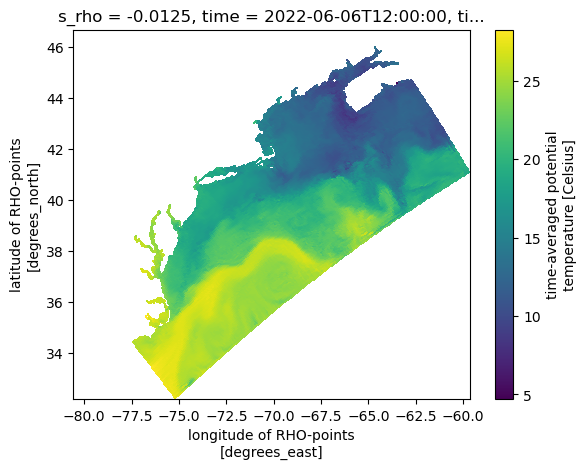

In [7]:
subset["temp"].squeeze().plot(x="lon_rho", y="lat_rho");

What is the current workflow and what are the altearnatives? Most ocean data are stored as modern netCDF files that are, under the hood HDF5 files with more strict metadata stuture. HDF5 has some limitations like,

- no thread-based parallelism
- cannot do parallel writes with compression
- no support for could object stores

However, for most workflows what really matters is the chunking, not the data format. Leaving the parallelism, compression, and cloud support to be built on top of it with `dask`, `numcodecs`, and `fsspec`, respectively. That raises the question: Should one convert all the existing data to `zarr`? Luckily no! We can adopt a more inexpensive workflow and kerchunk to create virtual cloud-optimized CF-compliant datasets that access files in any format using the Zarr library.

We can write the data in whatever format we need (maybe you are NASA and require HDF5, maybe you have R users who like netcdf, or want to use a visualization tool that only reads geotiff), then rechunk the data to best support the expected use cases.